# Install dependencies

In [2]:
%%capture

!pip install natsort
!git clone https://github.com/JaidedAI/EasyOCR.git

# for cer metric
!pip install jiwer

# for download easyocr pretrained model from google drive
!pip install gdown

# Imports

In [3]:
%%capture

import os
from os.path import join as opj

import cv2
import yaml
import gdown
import torch
import shutil
import pandas as pd
import easyocr
import numpy as np
import pandas as pd
import torch.backends.cudnn as cudnn
from PIL import Image
from lxml import etree
from copy import deepcopy
from tqdm.auto import tqdm
from datasets import load_metric
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

torch.backends.cudnn.benchmark = True # enable, because model will not change and it`s input sizes remain the same

In [38]:
DATASET_DIR = "/kaggle/input/easyocr-recognition-dataset/Recognition Dataset"
VAL_PERCENT, TEST_PERCENT = 0.2, 0.1 # dataset is divided into train, validation and test according to these values multiplied by 100%. TRAIN_PERCENT = 1 - (VAL_PERCENT + TEST_PERCENT)
OUT_MODEL_PATH = "/kaggle/working/model" # path to save trained model
os.makedirs(OUT_MODEL_PATH, exist_ok=True)
PREDICTION_ALLOW_LIST = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz-. " # allowed characters to predict when testing (paragraph "Test")

TEXTS_DATASET_DIR = "/kaggle/working/easyocr_split_data" # folder of new dataset for easyocr

# EASY_OCR_PRETRAINED_URL = "https://github.com/JaidedAI/EasyOCR/releases/download/v1.3/english_g2.zip" # url to google drive of pretrained easyocr model
EASY_OCR_PRETRAINED_URL = "https://drive.google.com/uc?id=1PIywV9_WZqNNfUIk6-bs598fX7OZTcbY"

EXPERIMENT_NAME = "num_plate_ocr" # custom name of model train/run
IMG_SIZE = (600, 64) # width and height of image size to train easyocr
NUM_TRAIN_ITERATIONS = 1000 # number of iterations to train. The number of iterations to use depends on the size of the dataset. Too many iterations can lead to overfitting, which can be detected by monitoring the validation loss during training. Too few iterations can result in underfitting, which can be identified by a consistently "sharp" decrease in the loss.
VAL_INTERVAL = 100 # evaluate model each X iterations
BATCH_SIZE = 64 # batch size per iteration. It is ideally in the form of a power of two (2, 4, 8)

In [5]:
# disable wandb
import wandb
wandb.init(mode="disabled")

In [6]:
%cd EasyOCR/trainer

/kaggle/working/EasyOCR/trainer


In [7]:
# rewriting source easyocr scripts to disable multiprocessing and fix bugs of new pytorch version

content = open("train.py").read()
content = content.replace("from test import validation", 
"""from importlib.machinery import SourceFileLoader
test = SourceFileLoader("test","test.py").load_module()
validation = test.validation""")
content = content.replace("prefetch_factor=512", "prefetch_factor=None")
with open("train.py", "w") as f:
    f.write(content)
    
content = open("dataset.py").read()
content = content.replace("data_loader_iter.next()", "next(data_loader_iter)")
content = content.replace("self.dataloader_iter_list[i].next()", "next(self.dataloader_iter_list[i])")
with open("dataset.py", "w") as f:
    f.write(content)

In [8]:
# import source easyocr code to train model
from train import train as ocr_train
from utils import AttrDict

In [9]:
# Load your labels
data_df = pd.read_csv(os.path.join(DATASET_DIR, 'labels.csv'))
print(data_df.head())


  filename       words
0    1.jpg  16-M2 6315
1   10.jpg  51A-775.29
2  100.jpg  51G-436.30
3  101.jpg   HAH-13-66
4  102.jpg  51G-510.08


In [13]:
# split dataframe on train/validation/test
train_df, nontrain_df = train_test_split(data_df, test_size=VAL_PERCENT+TEST_PERCENT, random_state=42)
val_df, test_df = train_test_split(nontrain_df, test_size=TEST_PERCENT/(VAL_PERCENT+TEST_PERCENT), random_state=42)

In [14]:
len(train_df), len(val_df), len(test_df)

(139, 40, 21)

In [15]:
os.makedirs(TEXTS_DATASET_DIR, exist_ok=True)

# Function to move files and write labels.csv
def save_split_data(df, split_name):
    split_path = os.path.join(TEXTS_DATASET_DIR, split_name)
    os.makedirs(split_path, exist_ok=True)

    for _, row in df.iterrows():
        filename = row['filename']
        src = os.path.join(DATASET_DIR, filename)
        dst = os.path.join(split_path, filename)

        if os.path.exists(src):
            shutil.copy(src, dst)  # use copy instead of move to preserve original dataset
        else:
            print(f"[WARNING] File not found: {src}")

    # Save labels
    df.to_csv(os.path.join(split_path, 'labels.csv'), index=False)

# Save each split
save_split_data(train_df, 'train')
save_split_data(val_df, 'val')
save_split_data(test_df, 'test')


In [16]:
# Get the current working directory
current_working_directory = os.getcwd()
print(current_working_directory)

/kaggle/working/EasyOCR/trainer


In [17]:
# download pretrained easyocr model
pretrained_easy_ocr_path = 'pretrained_easy_ocr.zip'
gdown.download(EASY_OCR_PRETRAINED_URL, pretrained_easy_ocr_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1PIywV9_WZqNNfUIk6-bs598fX7OZTcbY
To: /kaggle/working/EasyOCR/trainer/pretrained_easy_ocr.zip
100%|██████████| 15.3M/15.3M [00:00<00:00, 66.0MB/s]


'pretrained_easy_ocr.zip'

In [18]:
# read easyocr config file
def get_config(file_path):
    with open(file_path, 'r', encoding="utf8") as stream:
        opt = yaml.safe_load(stream)
    opt = AttrDict(opt)
    return opt


In [19]:
experiment_path = f'./saved_models/{EXPERIMENT_NAME}'
os.makedirs(experiment_path, exist_ok=True)

In [20]:
# load basic config
opt = get_config("config_files/en_filtered_config.yaml")

# remake config for finetuning cyrillic model
# opt["symbol"] = "\-."
# opt["lang_char"] = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
opt["symbol"] = "!\"#$%&'()*+,-./:;<=>?@[\\]№_`{|}~ €₽"
opt["lang_char"] = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюяЂђЃѓЄєІіЇїЈјЉљЊњЋћЌќЎўЏџҐґҒғҚқҮүҲҳҶҷӀӏӢӣӨөӮӯ"
opt["experiment_name"] = EXPERIMENT_NAME
opt["train_data"] = TEXTS_DATASET_DIR
opt["select_data"] = "train"
opt["valid_data"] = opj(TEXTS_DATASET_DIR, "val")
opt["num_iter"] = NUM_TRAIN_ITERATIONS
opt["batch_size"] = BATCH_SIZE
opt["batch_max_length"] = BATCH_SIZE
opt["FT"] = True # enable finetuning
opt["new_prediction"] = False # false to not start training from scratch
opt["saved_model"] = pretrained_easy_ocr_path # path to model for finetuning
opt["valInterval"] = VAL_INTERVAL
opt["batch_ratio"] = "1"
opt["workers"] = 0 # 0 workers to disable multiprocessing
opt["imgW"], opt["imgH"] = IMG_SIZE
opt["character"] = opt["number"] + opt["symbol"] + opt["lang_char"]

# Model Training

In [21]:
# train model
try:
    ocr_train(opt, amp=False)
except SystemExit:
    pass

Filtering the images containing characters which are not in opt.character
Filtering the images whose label is longer than opt.batch_max_length
--------------------------------------------------------------------------------
dataset_root: /kaggle/working/easyocr_split_data
opt.select_data: ['train']
opt.batch_ratio: ['1']
--------------------------------------------------------------------------------
dataset_root:    /kaggle/working/easyocr_split_data	 dataset: train
/kaggle/working/easyocr_split_data/train
sub-directory:	/train	 num samples: 139
num total samples of train: 139 x 1.0 (total_data_usage_ratio) = 139
num samples of train per batch: 64 x 1.0 (batch_ratio) = 64
--------------------------------------------------------------------------------
Total_batch_size: 64 = 64
--------------------------------------------------------------------------------
dataset_root:    /kaggle/working/easyocr_split_data/val	 dataset: /
/kaggle/working/easyocr_split_data/val/
sub-directory:	/.	 num

In [22]:
# save config file
saved_model_opt = {
    "lang_list": ["en"],
    "network_params": {
        "input_channel": opt["input_channel"],
        "output_channel": opt["output_channel"],
        "hidden_size": opt["hidden_size"]
    },
    "imgH": opt["imgH"],
    "character_list": opt["character"],
}
with open(opj(OUT_MODEL_PATH, EXPERIMENT_NAME + ".yaml"), "w") as outfile:
    yaml.dump(saved_model_opt, outfile, default_flow_style=False)

In [23]:
# save best weights
shutil.copy(opj(experiment_path, "best_norm_ED.pth"), opj(OUT_MODEL_PATH, EXPERIMENT_NAME + ".pth"))


'/kaggle/working/model/num_plate_ocr.pth'

In [24]:
# save module of classes to load weights
content = open("model.py").read()
content = content.replace("def __init__(self, opt):",
f"""def __init__(self, *args, **kwargs):
        opt = AttrDict({opt})""")
content = """class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
""" + content
with open(opj(OUT_MODEL_PATH, EXPERIMENT_NAME) + ".py", "w") as f:
    f.write(content)

shutil.copytree("modules", opj(OUT_MODEL_PATH, "modules"))

'/kaggle/working/model/modules'

In [25]:
reader = easyocr.Reader(["en"], 
                        model_storage_directory=OUT_MODEL_PATH,
                        user_network_directory=OUT_MODEL_PATH,
                        recog_network=EXPERIMENT_NAME)

Progress: |██████████████████████████████████████████████████| 100.0% CompleteNo Transformation module specified


In [26]:
instance_path = opj(TEXTS_DATASET_DIR, "test", os.listdir(opj(TEXTS_DATASET_DIR, "test"))[4])
result = reader.readtext(instance_path, allowlist=PREDICTION_ALLOW_LIST)
txt = "\n".join([elem[1] for elem in result])
print(txt)

GEEKLYR


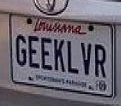

In [27]:
Image.open(instance_path)

# Model Evaluation

In [28]:
test_df

,filename,words
95,185.jpg,LFC1
115,22.jpg,51F-065.32
29,125.jpg,60A-208.80
18,115.jpg,51F-079.73
78,17.jpg,51A-012.04
73,165.jpg,59-L2 231.64
150,54.jpg,51F-491.42
86,177.jpg,51G-254 81
165,68.jpg,GEEKLVR
79,170.jpg,63721-BA


In [42]:
from Levenshtein import distance as levenshtein_distance

In [43]:
# === Evaluation Loop ===
total_chars = 0
correct_chars = 0
total_words = len(test_df)
correct_words = 0
levenshtein_total = 0

predicted_list = []

for i, row in test_df.iterrows():
    filename = row['filename']
    gt_text = str(row['words']).strip()
    img_path = opj(TEXTS_DATASET_DIR, "test", filename)

    if not os.path.exists(img_path):
        print(f"Missing image: {img_path}")
        predicted_list.append("")
        continue

    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    result = reader.readtext(gray, allowlist=PREDICTION_ALLOW_LIST)
    pred_text = result[0][1].strip() if result else ""

    predicted_list.append(pred_text)

    # Char-level accuracy
    total_chars += len(gt_text)
    correct_chars += sum(1 for a, b in zip(gt_text, pred_text) if a == b)

    # Word-level accuracy
    if gt_text == pred_text:
        correct_words += 1

    # Levenshtein Distance
    levenshtein_total += levenshtein_distance(gt_text, pred_text)

# === Final Scores ===
char_acc = correct_chars / total_chars if total_chars else 0
word_acc = correct_words / total_words if total_words else 0
avg_lev = levenshtein_total / total_words if total_words else 0

# === Output Results ===
test_df['prediction'] = predicted_list
test_df.to_csv("ocr_test_results.csv", index=False)

print(f"Character-level Accuracy: {char_acc:.4f}")
print(f"Word-level Accuracy: {word_acc:.4f}")
print(f"Average Levenshtein Distance: {avg_lev:.2f}")

Character-level Accuracy: 0.6041
Word-level Accuracy: 0.4762
Average Levenshtein Distance: 3.48


In [44]:
test_df

,filename,words,prediction
95,185.jpg,LFC1,11
115,22.jpg,51F-065.32,51F
29,125.jpg,60A-208.80,60A-208.80
18,115.jpg,51F-079.73,51F-079.73
78,17.jpg,51A-012.04,51A-012.04
73,165.jpg,59-L2 231.64,59 LZ
150,54.jpg,51F-491.42,42
86,177.jpg,51G-254 81,51G-254 81
165,68.jpg,GEEKLVR,K978
79,170.jpg,63721-BA,
